In [3]:
%load_ext autoreload

In [38]:
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import sys
from tqdm.auto import tqdm

sys.path.append('../../..')
from nld_utils import simulate_lorenz

In [190]:
def RK4(func, t0, y0, t_bound, dt=0.1, verbose=False):
    y_vals = np.zeros((int(t_bound/dt), len(y0)))
    t_vals = np.arange(t0, t0 + t_bound, dt)
    y = y0
    y_vals[0] = y
    for i, t in tqdm(enumerate(t_vals[:-1]), disable=not verbose, total=len(t_vals) - 1):
        k1 = func(t, y)
        k2 = func(t + dt/2, y + dt*k1/2)
        k3 = func(t + dt/2, y + dt*k2/2)
        k4 = func(t + dt, y + dt*k3)
        y += (1/6)*(k1 + 2*k2 + 2*k3 + k4)*dt
        y_vals[i + 1] = y
    
    return y_vals, t_vals

def lorenz(t, pt, rho=28, beta=8/3, sigma=10):
    x, y, z = pt[0], pt[1], pt[2]
    return np.array([sigma*(y - x), x*(rho - z) - y, x*y - beta*z])

In [214]:
dt = 0.001
t_bound = 50
lorenz_pts, time = RK4(lorenz, 0, np.random.randn(3), t_bound, dt=dt, verbose=True)

  0%|          | 0/49999 [00:00<?, ?it/s]

In [215]:
# dt = 0.0001
# T = 50
# lorenz_pts = simulate_lorenz(T=T, dt=dt, rho=28, beta=8 / 3, sigma=10)

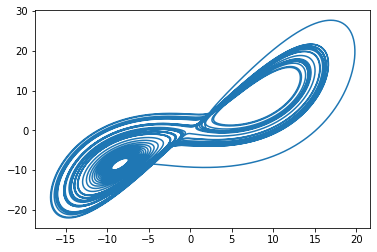

In [216]:
plt.plot(lorenz_pts[:, 0], lorenz_pts[:, 1])
plt.show()

In [217]:
def lorenz_jacobian(pt, rho=28, beta=8/3, sigma=10):
    x, y, z = pt[0], pt[1], pt[2]
    J = np.array([[-sigma, sigma, 0], [rho - z, -1, -x], [y, x, -beta]])
    return J

def L_stab_mat(J, e, _beta):
    L = np.zeros(J.shape)
    for i in range(L.shape[0]):
        for j in range(L.shape[1]):
            if i == j:
                L[i, j] = np.dot(e[:,i], J @ e[:, j]) + _beta*np.dot(e[:, i], e[:, j] - 1)
            else:
                L[i, j] = np.dot(e[:,i], J @ e[:, j]) + np.dot(e[:,j], J @ e[:, i]) + 2*_beta*np.dot(e[:, i], e[:, j])
    return L

In [218]:
def CGSO_func(t, pt, system_pts, jacobian_func, L_func, _beta, dt):
    k = system_pts.shape[1]
    e = pt[:k**2].reshape(k, k)
    Lambda = pt[-k:]
    
    J = jacobian_func(system_pts[int(t/dt)])
    L = L_func(J, e, _beta)
    
    de = np.zeros((k, k))
    dLambda = np.zeros(k)
    for m in range(k):
        de[:, m] = J @ e[:, m] - e[:, l]*np.sum([L[l,  m] for l in range(m + 1)])
        dLambda[m] = np.dot(e[:, m], J @ e[:, m])
    
    dX = np.hstack([de.flatten(), dLambda])
    
    return dX

In [236]:
_beta = 1000
func = lambda t, y: CGSO_func(t, y, system_pts=lorenz_pts, jacobian_func=lorenz_jacobian, L_func=L_stab_mat, _beta=_beta, dt=dt)
t0 = 0
y0 = np.hstack([np.eye(lorenz_pts.shape[1]).flatten(), np.random.randn(lorenz_pts.shape[1])*0.01])
CGSO_pts, time2 = RK4(func, t0, y0, t_bound, dt=dt, verbose=True)

  0%|          | 0/49999 [00:00<?, ?it/s]

In [237]:
d = lorenz_pts.shape[1]

In [238]:
e = CGSO_pts[:, :d**2].reshape(CGSO_pts.shape[0], d, d)
Lambda = CGSO_pts[:, -d:]

In [239]:
dot_prod = np.zeros(e.shape[0])
for t in range(e.shape[0]):
    dot_prod[t] = e[t][:, 0] @ e[t][:, 1]

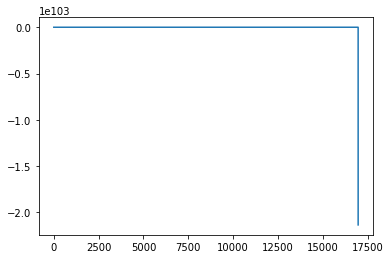

In [242]:
plt.plot(dot_prod[:int(20/dt)])

In [243]:
lambda_vals = np.zeros(Lambda.shape)
for i in range(d):
    lambda_vals[:, i] = Lambda[:, i]/np.arange(t0 + dt, t0+t_bound + dt, dt)

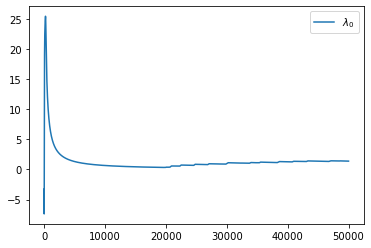

In [245]:
start = 0 # s
end = t_bound # s
i_to_plot = [0]
for i in range(d):
    if i in i_to_plot:
        plt.plot(lambda_vals[int(start/dt):int(end/dt), i], label=fr"$\lambda_{i}$")
plt.legend()
plt.show()

# OLD METHOD

In [122]:
# continuous gram schmidt orthonormalization
def CGSO(pts, jacobian_func, L_func, dt, _beta, verbose=False):
    T = pts.shape[0]
    k = pts.shape[1]
    e = np.zeros((T, k, k))
    Lambda = np.zeros((T, k))
    
    e[0] = np.eye(k)
    Lambda[0] = np.random.randn(k)*0.1
    for t in tqdm(range(1, T), disable = not verbose):
        J = jacobian_func(pts[t - 1])
        L = L_func(J, e[t-1], _beta)
        de = np.zeros((k, k))
        dLambda = np.zeros(k)
        for m in range(k):
            de[:, m] = J @ e[t - 1, :, m] - e[t - 1, :, l]*np.sum([L[l,  m] for l in range(m + 1)])
            dLambda[m] = np.dot(e[t - 1, :, m], J @ e[t - 1, :, m])
        
        e[t] = e[t - 1] + dt*de
        Lambda[t] = Lambda[t - 1] + dt*dLambda

    return e, Lambda

In [123]:
_beta = 15
verbose = True
e, Lambda = CGSO(lorenz_pts, lorenz_jacobian, L_stab_mat, dt, _beta, verbose)

  0%|          | 0/499999 [00:00<?, ?it/s]

/tmp/ipykernel_29548/1764012798.py:13: RuntimeWarning: invalid value encountered in matmul
  L[i, j] = np.dot(e[:,i], J @ e[:, j]) + np.dot(e[:,j], J @ e[:, i]) + 2*_beta*np.dot(e[:, i], e[:, j])
/tmp/ipykernel_29548/1764012798.py:11: RuntimeWarning: invalid value encountered in matmul
  L[i, j] = np.dot(e[:,i], J @ e[:, j]) + _beta*np.dot(e[:, i], e[:, j] - 1)
/tmp/ipykernel_29548/4139223381.py:16: RuntimeWarning: invalid value encountered in matmul
  de[:, m] = J @ e[t - 1, :, m] - e[t - 1, :, l]*np.sum([L[l,  m] for l in range(m + 1)])
/tmp/ipykernel_29548/4139223381.py:17: RuntimeWarning: invalid value encountered in matmul
  dLambda[m] = np.dot(e[t - 1, :, m], J @ e[t - 1, :, m])


In [109]:
(Lambda[:, 0]/(np.arange(dt, T + dt, dt)))[-1]

0.45292325845901826

In [110]:
(Lambda[:, 1]/(np.arange(dt, T + dt, dt)))[-1]

-0.05486409427837757

In [111]:
(Lambda[:, 2]/(np.arange(dt, T + dt, dt)))[-1]

0.0013337702183769573

In [ ]:
dot_prod = np.zeros(e.shape[0])
for t in range(e.shape[0]):
    dot_prod[t] = e[t][:, 0] @ e[t][:, 1]

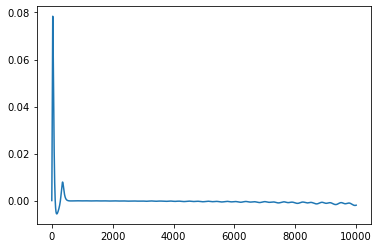

In [124]:
plt.plot(dot_prod)